# Consensus Pipeline Demo Notebook

This notebook is designed to showcase some of the features provided by OpenMRSLab and the Suspect package for handling single voxel MRS data.

In [1]:
import numpy as np
import nipype
from nipype.interfaces import fsl
import suspect
import os

import matplotlib.pyplot as plt

In [67]:
%matplotlib notebook

In this example we are working with some SVS PRESS data in the Siemens twix format. We have both a standard water suppressed file and a water reference, and there is also a Nifti file with a T1 MPRAGE image.

In [2]:
data_file = "meas_MID00062_FID19147_svs_se_30_PCC.dat"
wref_file = "meas_MID00063_FID19148_svs_se_30_PCC_wref.dat"
t1_file = os.path.abspath("t1.nii")

In [3]:
t1 = suspect.image.load_nifti(t1_file)
data = suspect.io.load_twix(data_file)
wref = suspect.io.load_twix(wref_file)

Loading the twix data creates objects of the MRSData class. This class has various properties to allow us to probe the acquisition parameters, and also overrides the Python `__repr__()` function so that when we just print the `data` object, rather than a huge table of numbers we get a short representation with some key parameters included.

In [64]:
print(data)
print(data.sw)
print(data.metadata)
print(data.shape)

<MRSBase instance f0=123.253243MHz TE=30.0ms dt=0.41670000000000007ms>
2399.808015358771
{'patient_name': 'xxxxxxxxxx', 'patient_id': 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'patient_birthdate': 'xxxxxxxx', 'exam_date': 'xxxxxx', 'exam_time': 'xxxxxx'}
(128, 32, 2048)


As you can see from the `shape` property above, this dataset has 128 averages, 32 channels and 2048 ADC points in the FID, but there is an additional axis here with size 2. This is because with the VE software release Siemens uses a prospective frequency correction method where the excited signal from the WET water suppression pulses is collected and used to adjust the scanner frequency to correct for any instability in the signal. We don't want to use that data, so we extract only the other part of the signal, the part that we really care about.

In [5]:
data = data[:, 1]
wref = wref[:, 1]

## Channel Combination
Because this is multi-channel data, there is likely to be some level of correlation between some of the channels. We can check this by looking at the pure noise signal at the end of the FIDs. From the covariance matrix below we can see that there is indeed substantial correlation between various pairs of coils, and also variation in the magnitude of the signal from different coils.

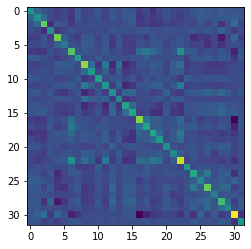

In [6]:
noise_points = 256
noise = data[:, :, -noise_points:]
noise = np.moveaxis(noise, -2, 0).reshape((32, -1))
plt.imshow(np.cov(noise).real)

We can correct for this and "whiten" the noise using the method described in Rodgers, C. T., & Robson, M. D. (2010). Receive array magnetic resonance spectroscopy: Whitened singular value decomposition (WSVD) gives optimal Bayesian solution. Magnetic Resonance in Medicine, 63(4), 881–891. This creates a set of "virtual channels" as linear combinations of the real channels, producing zero correlation and equal magnitude of each channel.

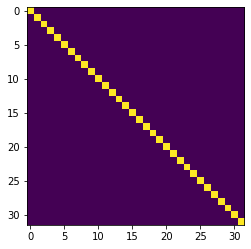

In [7]:
white_data = suspect.processing.channel_combination.whiten(data, noise)
white_wref = suspect.processing.channel_combination.whiten(wref, noise)
noise = white_data[:, :, -noise_points:]
noise = np.moveaxis(noise, -2, 0).reshape((32, -1))
plt.imshow(np.cov(noise).real)

We then combine these virtual channels using the SVD weighting method proposed in the same paper. In this case we take the weightings for both datasets from the water reference signal for consistency, as the water reference has a greater overall SNR.

In [8]:
channel_weights = suspect.processing.channel_combination.svd_weighting(np.mean(white_wref, axis=0))
cc_data = suspect.processing.channel_combination.combine_channels(white_data, channel_weights)
cc_wref = suspect.processing.channel_combination.combine_channels(white_wref, channel_weights)

## Frequency Drift Correction
Now it is time to check for frequency drift. In this demonstration we use a visualisation method borrowed from GANNET where we show the sequence of spectra as a heatmap. We can easily convert from a time domain FID representation of the data to spectra using the `spectrum()` method of the MRSData class. We then use the `slice_ppm()` method to index into the spectra in the range of frequencies we are interested in.

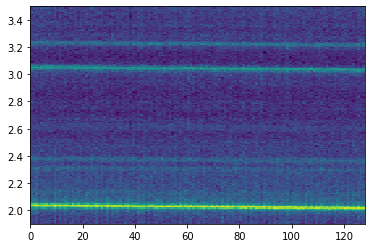

In [56]:
spectra = cc_data.spectrum()
frequency_slice = spectra.slice_ppm(3.5, 1.9)
plt.imshow(spectra[:, frequency_slice].T.real, extent=[0, 128, 1.9, 3.5], aspect='auto')

Despite the prospective frequency correction, a fairly pronounced drift in frequency is still visible over the 128 averages, this adds up to about 3Hz first spectrum to last. We can correct for that using Jamie Near's time domain Spectral Registration method. We use the first average in the list as the target and iterate over all averages, correcting them to maximum alignment with that target. Note that alternative methods such as Martin Wilson's RATS are also available. We also take the opportunity to make the same correction to the water reference data, although the drift in that case is likely minimal due to the reduced number of averages. Plotting the heatmap on the aligned data we can see that the drift is removed very effectively.

In [10]:
sr_data = suspect.processing.frequency_correction.correct_frequency_and_phase(cc_data, cc_data[0], method="sr")
sr_wref = suspect.processing.frequency_correction.correct_frequency_and_phase(cc_wref, cc_wref[0], method="sr")

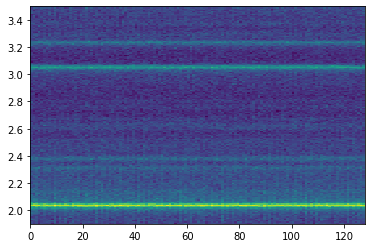

In [57]:
sr_spectra = sr_data.spectrum()
frequency_slice = sr_spectra.slice_ppm(3.5, 1.9)
plt.imshow(sr_spectra[:, frequency_slice].T.real, extent=[0, 128, 1.9, 3.5], aspect='auto')

With the frequency drift corrected, we can now combine the averages using a simple `mean()` function.

In [12]:
ave_data = np.mean(sr_data, axis=0)
ave_wref = np.mean(sr_wref, axis=0)

## Eddy Current Correction
The next step to consider is eddy current correction, which we analyse in the water reference data. We can very easily get the eddy current effect using standard NumPy functions.

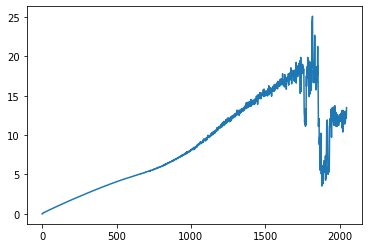

In [13]:
plt.plot(np.unwrap(np.angle(ave_wref)))

In this case we do see substantial eddy current effects, so we will calculate a correction term. Here we use a denoising function from Suspect to smooth out the curve, although we can't really do anything at the end of the acquisition window where the signal is pure noise, it doesn't matter what we do to the signal there anyway. Replotting the corrected water reference phase evolution shows no discernable eddy current effects.

In [14]:
eddy_current = np.unwrap(np.angle(ave_wref))
ec_smooth = suspect.processing.denoising.sliding_gaussian(eddy_current, 32)
ecc = np.exp(-1j * ec_smooth)

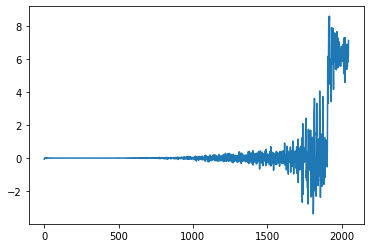

In [15]:
ec_data = ave_data * ecc
ec_wref = ave_wref * ecc
plt.plot(np.unwrap(np.angle(ec_wref)))

It is finally time to plot our spectrum. Again we make use of a helper method of the MRSData class to generate a frequency axis in ppm to match our spectral data.

(5, 0)

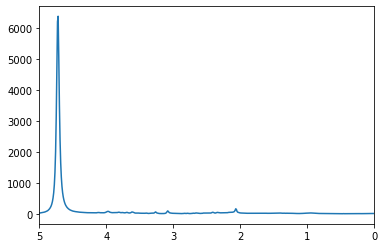

In [16]:
plt.plot(ec_data.frequency_axis_ppm(), ec_data.spectrum().real)
plt.xlim([5, 0])

## Residual Water Removal
Oops! There is still a lot of residual water left in the signal, much bigger than the metabolite peaks. We could leave this to Tarquin to take out, but why not do it ourselves? We use the HSVD method to decompose the FID into exponential decay signals, then we select all those signals with a frequency below 60 Hz from centre, assuming those to be only parts of the water peak. We construct a new FID from those components which represents the pure residual water signal.

(5, 0)

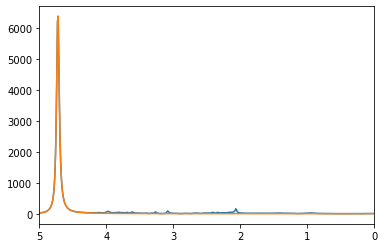

In [17]:
components = suspect.processing.water_suppression.hsvd(ec_data, 30)
water_components = [component for component in components if component["frequency"] < 60]
water_fid = ec_data.inherit(suspect.processing.water_suppression.construct_fid(water_components, ec_data.time_axis()))
plt.plot(ec_data.frequency_axis_ppm(), ec_data.spectrum().real)
plt.plot(water_fid.frequency_axis_ppm(), water_fid.spectrum().real)
plt.xlim([5, 0])

Now we can subtract out that water signal and at last plot our final spectrum.

(5, 0)

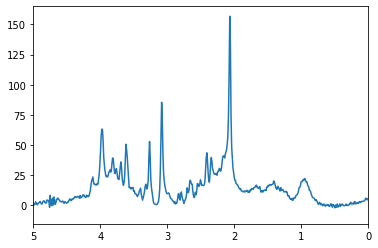

In [18]:
dry_data = ec_data - water_fid
plt.plot(dry_data.frequency_axis_ppm(), dry_data.spectrum().real)
plt.xlim(5, 0)

## Absolute Quantification
Now before doing a fitting step, we need to make some calculations to get parameters to allow us to do absolute quantification. We define a little function using NiPype, which allows us to run FSL routines from Python, in this case to run the BET and FAST programs to remove the brain from our T1 image and classify it into grey matter, white matter and CSF.

In [20]:
def classify_tissues(t1_file):
    """
    Given a NIFTI file containing a T1 head image, run the FSL tools BET and FAST
    to extract the brain and classify it into white matter, grey matter and CSF
    labels, then return 3 image volumes with the voxelwise probabilities of
    membership of each label.
    """
    workflow = nipype.Workflow(name="classify_tissues")
    bet = nipype.Node(fsl.BET(frac=0.5,
                              robust=True),
                      name="bet")
    fast = nipype.Node(fsl.FAST(output_type="NIFTI",
                                number_classes=3),
                       name="fast")
    workflow.connect([(bet, fast, [("out_file", "in_files")])])
    bet.inputs.in_file = os.path.abspath(t1_file)
    result = workflow.run()
    for node in result.nodes():
        if node.name == "fast":
            wm = suspect.image.load_nifti(node.result.outputs.partial_volume_files[2])
            gm = suspect.image.load_nifti(node.result.outputs.partial_volume_files[1])
            csf = suspect.image.load_nifti(node.result.outputs.partial_volume_files[0])
    return wm, gm, csf

In [21]:
wm, gm, csf = classify_tissues(t1_file)

200622-22:58:40,226 workflow INFO:
	 Workflow classify_tissues settings: ['check', 'execution', 'logging', 'monitoring']
200622-22:58:40,265 workflow INFO:
	 Running serially.
200622-22:58:40,267 workflow INFO:
	 [Node] Setting-up "classify_tissues.bet" in "/tmp/tmpwozt6c17/classify_tissues/bet".
200622-22:58:40,279 workflow INFO:
	 [Node] Running "bet" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /home/jovyan/work/consensus/t1.nii /tmp/tmpwozt6c17/classify_tissues/bet/t1_brain.nii.gz -f 0.50 -R
200622-22:58:55,202 workflow INFO:
	 [Node] Finished "classify_tissues.bet".
200622-22:58:55,204 workflow INFO:
	 [Node] Setting-up "classify_tissues.fast" in "/tmp/tmpv796466a/classify_tissues/fast".
200622-22:58:55,215 workflow INFO:
	 [Node] Running "fast" ("nipype.interfaces.fsl.preprocess.FAST"), a CommandLine Interface with command:
fast -n 3 -S 1 /tmp/tmpv796466a/classify_tissues/fast/t1_brain.nii.gz
200622-23:03:29,43 workflow INFO:
	 [Node] Finish

Now we create a mask of the image voxels which are inside the PRESS box. From our tissue label maps we can work out the fraction of each tissue type found in the voxel. Luckily the fractions all add up to 1. We then use Suspect to calculate the molar concentration factor which converts the ratio of metabolite to water peak to a metabolite molar concentration.

In [19]:
voxel_mask = suspect.image.create_mask(data, t1)

In [22]:
voxel_volume = np.sum(voxel_mask)
f_wm = np.sum(wm * voxel_mask) / voxel_volume
f_gm = np.sum(gm * voxel_mask) / voxel_volume
f_csf = np.sum(csf * voxel_mask) / voxel_volume

In [23]:
print(f_csf + f_wm + f_gm)

1.0000000001734588


In [24]:
aq_factor = suspect.fitting.molar_concentration_factor(f_wm, f_gm, f_csf, data.te, data.tr)
print(aq_factor)

34152.7768105297


## Fitting
We can now pass the data, water reference and absolute quantification factor into the Tarquin fitting program, which will then return the fitting results back to us. We get Tarquin's processed version of the data, its fit and baseline estimates, as well as lines for each metabolite in the basis set.

In [26]:
fit = suspect.fitting.tarquin.process(dry_data, ec_wref, aq_factor=aq_factor)

(5, 0.0)

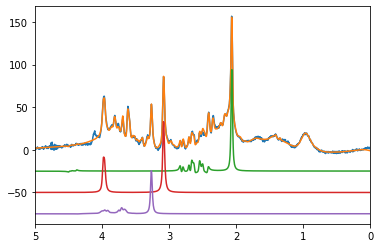

In [38]:
plt.plot(fit["plots"]["data"].frequency_axis_ppm(), fit["plots"]["data"].real)
plt.plot(fit["plots"]["data"].frequency_axis_ppm(), fit["plots"]["fit"].real + fit["plots"]["baseline"].real)
plt.plot(fit["plots"]["data"].frequency_axis_ppm(), fit["plots"]["metabolites"]["NAA"].real - 25)
plt.plot(fit["plots"]["data"].frequency_axis_ppm(), fit["plots"]["metabolites"]["Cr"].real + fit["plots"]["metabolites"]["PCr"].real - 50)
plt.plot(fit["plots"]["data"].frequency_axis_ppm(), fit["plots"]["metabolites"]["GPC"].real - 75)
plt.xlim([5, 0.0])

Of course, we also get the numerical information about the metabolite concentrations and standard deviations, and we also get the fit quality information provided by Tarquin.

In [37]:
fit["metabolite_fits"]

{'-CrCH2': {'concentration': '0.000', 'sd': 'inf'},
 'Ala': {'concentration': '0.000', 'sd': 'inf'},
 'Asp': {'concentration': '5.661', 'sd': '8.240'},
 'Cr': {'concentration': '6.281', 'sd': '3.897'},
 'GABA': {'concentration': '2.338', 'sd': '21.69'},
 'GPC': {'concentration': '1.743', 'sd': '3.229'},
 'Glc': {'concentration': '0.5556', 'sd': '35.49'},
 'Gln': {'concentration': '0.000', 'sd': 'inf'},
 'Glth': {'concentration': '2.707', 'sd': '6.444'},
 'Glu': {'concentration': '11.24', 'sd': '3.326'},
 'Ins': {'concentration': '6.797', 'sd': '2.097'},
 'Lac': {'concentration': '0.2822', 'sd': '37.89'},
 'Lip09': {'concentration': '1.895', 'sd': '58.48'},
 'Lip13a': {'concentration': '5.271', 'sd': '225.0'},
 'Lip13b': {'concentration': '0.000', 'sd': 'inf'},
 'Lip20': {'concentration': '6.775', 'sd': '19.72'},
 'MM09': {'concentration': '6.107', 'sd': '20.49'},
 'MM12': {'concentration': '1.980', 'sd': '293.0'},
 'MM14': {'concentration': '3.175', 'sd': '562.0'},
 'MM17': {'concentra

In [59]:
print(fit["quality"])

{'Metab FWHM (PPM)': 0.02614, 'Metab FWHM (Hz)': 3.222, 'SNR residual': 49.81, 'SNR max': 171.3, 'Q': 3.439}


## Voxel Plotting
As a final demonstration, we render the PRESS box on top of the anatomical image. Both MRS and MRI objects have affine transforms relating their internal grids to the scanner coordinate system, so we can easily convert the `position` property of `data` (the centre of the PRESS box) into a voxel of the T1 image, telling us which slice passes through the centre of the MRS voxel. We then define a square of coordinates around the edges of the MRS voxel which are converted first from MRS to scanner coordinates, then into T1 coordinates, where they are then ready for plotting on the displayed image.

In [46]:
voxel_centre_index = t1.from_scanner(*data.position).round().astype(int)
corner_coords_voxel = [[0, -0.5, -0.5],
                     [0, 0.5, -0.5],
                     [0, 0.5, 0.5],
                     [0, -0.5, 0.5],
                     [0, -0.5, -0.5]]
corner_coords = np.array([t1.from_scanner(*data.to_scanner(*coord)) for coord in corner_coords_voxel])

<IPython.core.display.Javascript object>


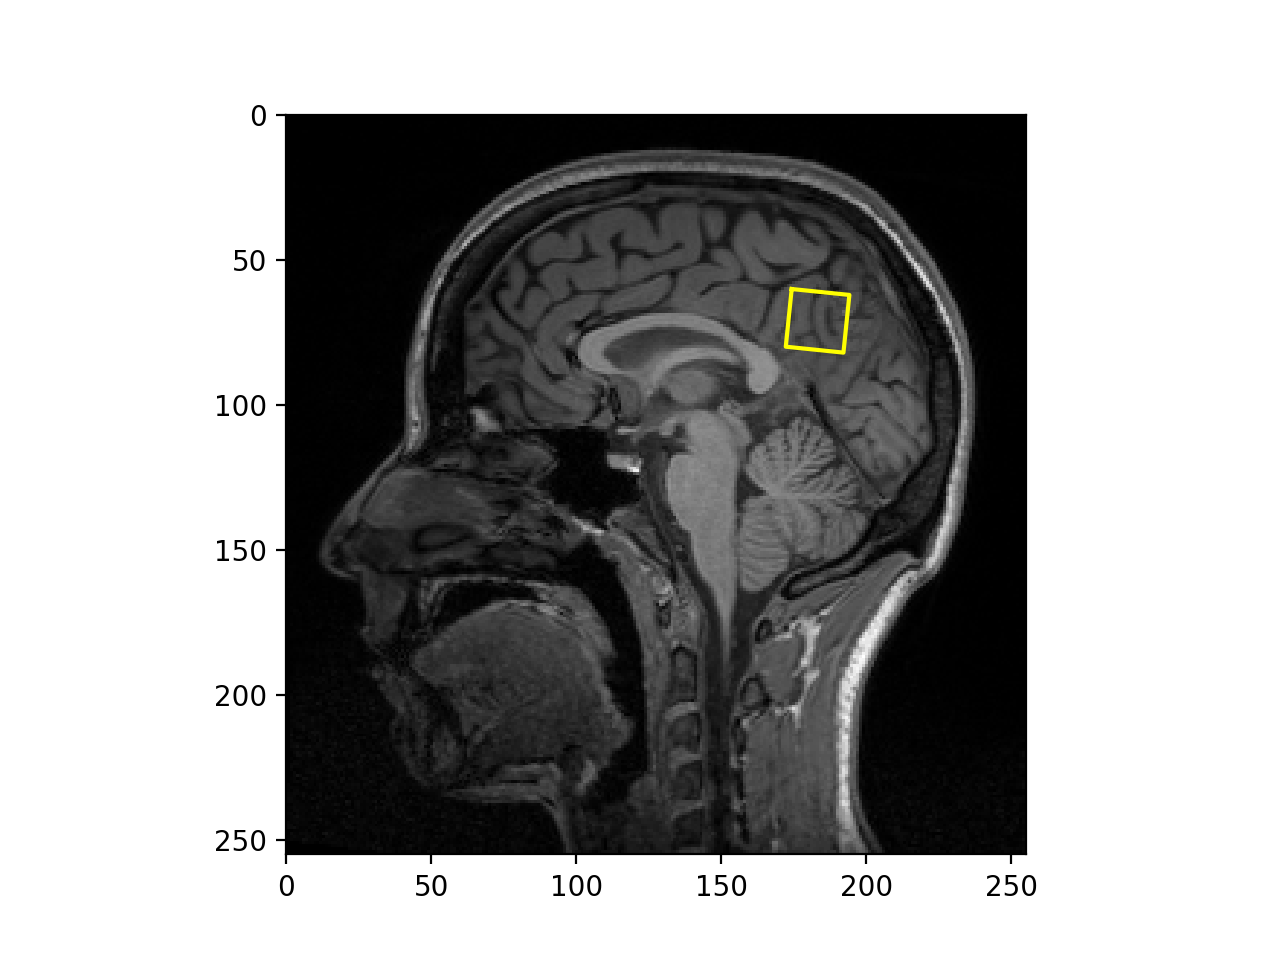

(255, 0)

In [68]:
plt.imshow(t1[voxel_centre_index[2]], cmap=plt.cm.gray)
plt.plot(corner_coords[:, 0], corner_coords[:, 1], 'yellow')
plt.xlim([0, t1.shape[2] - 1])
plt.ylim([t1.shape[1] - 1, 0])